In [1]:
# Wczytaj obrazy I.jpg i J.jpg. B˛ed ˛a to dwie ramki
# z sekwencji, oznaczone jako I i J (odpowiednio wcze´sniejsza i pó´zniejsza ramka). Opcjo-
# nalnie mo˙zesz zmniejszy´c oba obrazy na czas testów, np. czterokrotnie – obliczenia b˛ed ˛a
# si˛e wykonywały szybciej. Wykonaj konwersj˛e obrazów do odcieni szaro´sci – cvtColor.
# Wy´swietl zadane obrazy – przydatne mo˙ze by´c wy´swietlanie przy u˙zyciu namedWindow
# oraz imshow. Zwizualizuj ró˙znic˛e, wykorzystuj ˛ac polecenie: absdiff.

import cv2
import numpy as np
import matplotlib.pyplot as plt

I = cv2.imread("I.jpg")
J = cv2.imread("J.jpg")

I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
J = cv2.cvtColor(J, cv2.COLOR_BGR2GRAY)

testI = cv2.resize(I, (0,0), fx=0.25, fy=0.25)
testJ = cv2.resize(J, (0,0), fx=0.25, fy=0.25)


diff = cv2.absdiff(testI, testJ)
diff = cv2.resize(diff, (0,0), fx=4, fy=4)

cv2.imshow("diff", diff)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [2]:
def loadAndPrepareImages(path1, path2, scale = 1.0):
    I = cv2.imread(path1)
    J = cv2.imread(path2)

    I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
    J = cv2.cvtColor(J, cv2.COLOR_BGR2GRAY)

    I = cv2.resize(I, (0,0), fx=scale, fy=scale)
    J = cv2.resize(J, (0,0), fx=scale, fy=scale)

    return I, J
# 2. Wykorzystuj ˛ac poni˙zsze wskazówki, zaimplementuj metodę blokową wyznaczania prze-
# pływu optycznego. Przyjmij następuj ˛ace założenia – porównujemy fragmenty obrazu
# o rozmiarze 7 × 7. Wykorzystywane dalej oznaczenia oraz wartości dla okna 7 × 7:
# W 2 = 3 – wartość całkowita z połowy rozmiaru okna,
# • dX = dY = 3 – rozmiar przeszukiwania (maksymalnego przesuwania okna) w obu
# kierunkach.

def blockMethod(img1, img2, W2 = 3, dX = 3):
    u = np.zeros(img1.shape)
    v = np.zeros(img1.shape)

    #Implementacje nalezy zaczac od dwóch petli for po obrazie. Wykorzystaj parametr
    # W 2 do warunku uwzgledniajacego przypadek brzegowy – zakładamy, ze na brzegu nie
    # wyliczamy przepływu optycznego.
    for j in range(W2, img1.shape[0] - W2):
        for i in range(W2, img1.shape[1] - W2):
            # Wewnatrz petli wycinamy fragment ramki I. Dla przypomnienia, niezbedna składnia to:
            # IO = np.float32(I[j-W2:j+W2+1,i-W2:i+W2+1])
            IO = np.float32(img1[j-W2:j+W2+1, i-W2:i+W2+1])
            minDist = np.inf
            #Nastepnie realizujemy kolejne dwie petle for – przeszukiwanie otoczenia piksela J(j,i).
            # Maja one zakres od −dX do dX i −dY do dY  „+1”. Wewnatrz
            # petli nalezy sprawdzic, czy współrzedne aktualnego kontekstu (tj. jego srodek) mieszcza
            # sie w dopuszczalnym zakresie. Alternatywnie mozna tez zmodyfikowac zakres zewnetrz-
            # nych petli – tak aby wykluczyc dostep do pikseli spoza dopuszczalnego zakresu. W tym
            # przypadku dla nieco szerszego brzegu przepływ nie zostanie okreslony, jednak nie ma to
            # istotnego znaczenia praktycznego.
            for m in range(-dX, dX+1):
                for n in range(-dX, dX+1):
                    # Wycinamy otoczenie JO, dokonujemy konwersji na float32 a nastepnie obliczamy „odleglosc” miedzy wycinkami IO a JO.
                    if j+m-W2 >= 0 and j+m+W2 < img2.shape[0] and i+n-W2 >= 0 and i+n+W2 < img2.shape[1]:
                        JO = np.float32(img2[j+m-W2:j+m+W2+1, i+n-W2:i+n+W2+1])
                        dist = np.sqrt(np.sum((np.square(JO-IO))))
                        # Sposrod wszystkich wycinków z JO dla danego IO nalezy znalezc najmniejsza „odległość” – lokalizacje „najbardziej podobnego”
                        if dist < minDist:
                            minDist = dist
                            u[j, i] = m
                            v[j, i] = n
    # Uzyskane współrzedne znalezionych minimów nalezy zapisać w dwóch macierzach u, v
    return u, v


u, v = blockMethod(testI, testJ)

# Wyznaczone pole przepływu optycznego mozna zwizualizowac na dwa sposoby – poprzez wektory (strzałki) – funkcja plt.quiver z biblioteki matplotlib lub kolory – zrealizujemy drugie z tych podejśc. 
# Pomysł opiera sie na okresleniu kąta i długości wektora wyznaczonego przez dwie składowe przepływu optycznego u i v dla kazdego piksela.
# Otrzymamy wówczas reprezentacje danych podobną jak w przestrzeni barw HSV. Po wyświetleniu kolor oznacza kierunek, w którym przemieszczają sie piksele, natomiast jego nasycenie informuje o względnej szybkości ruchu pikseli – przeanalizuj koło kolorów na rys. 4.2.
# Dokonaj konwersji wyznaczonego przepływu do układu współrzednych biegunowych – cartToPolar. Utwórz zmienną na obraz w przestrzeni HSV o wymiarach wejściowego obrazu, 3 kanałach i typie uint8.
# Pierwszy kanał to składowa H, równa angle ∗ 90/np.pi (w Pythonie zakres od 0 do 180). Drugi kanał to składowa S – dokonaj normalizacji (normalize) długości wektora do przedziału 0-255. Trzeci kanał to składowa V, ustaw ją na 255.
# Aby brak ruchu oznaczony był kolorem czarnym, a nie białym, nalezy zamienić kanały S i V.
# Na koniec wykonaj konwersję obrazu do przestrzeni RGB i wyświetl go.

def draw_flow(I, u, v, scale = 1.0, show = True):
    mag, ang = cv2.cartToPolar(u, v)
    hsv = np.zeros((I.shape[0], I.shape[1], 3), dtype=np.uint8)
    hsv[..., 0] = ang * 90 / np.pi
    hsv[..., 1] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    hsv[..., 2] = 255

    # hsv[..., 1], hsv[..., 2] = hsv[..., 2], hsv[..., 1]

    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    rgb = cv2.resize(rgb, (0,0), fx=scale, fy=scale)

    if show:
        cv2.imshow("rgb", rgb)

        cv2.waitKey(0)
        cv2.destroyAllWindows()

        plt.imshow(rgb)
    else:
        return rgb


def pipeline(path1, path2, scale = 1.0, W2 = 3, dX = 3, save = False):
    I, J = loadAndPrepareImages(path1, path2, scale)
    u, v = blockMethod(I, J, W2, dX)
    draw_flow(I, u, v, (1/scale), show = not save)
              






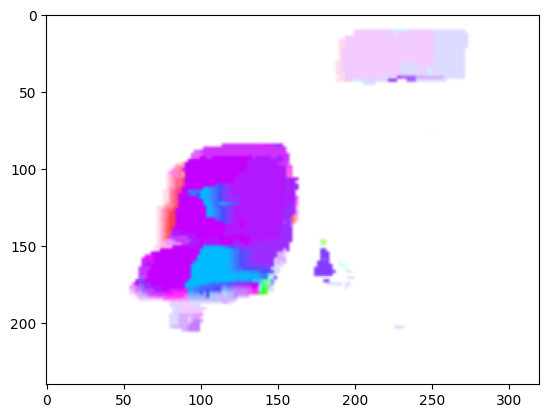

In [3]:

pipeline("I.jpg", "J.jpg", 0.5, 5, 5)


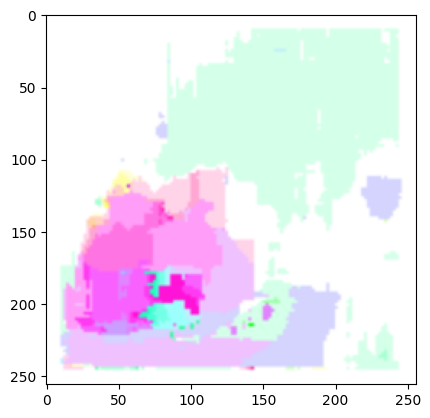

In [4]:
pipeline("cm1.png", "cm2.png", 0.5, 5, 5)

In [5]:
I, J = loadAndPrepareImages("I.jpg", "J.jpg", 0.5)
u, v = blockMethod(I, J, 5, 5)
block = draw_flow(I, u, v, 0.5, False)


(60, 80, 3)


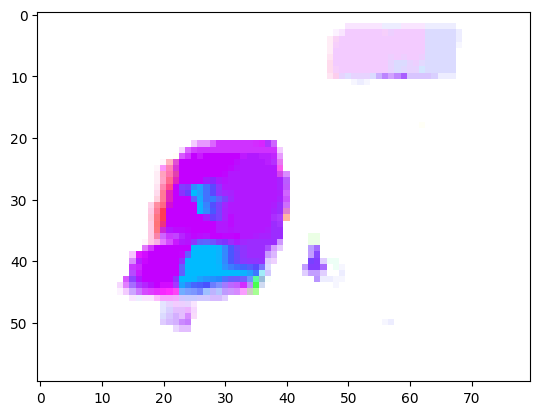

In [7]:
print(block.shape)

plt.imshow(block)

In [9]:
# Zaimplementuj wieloskalowa wersj ̨e metody blokowej do wyznaczania
# przepływu optycznego.
# 1. Na wstepie prosz ̨e stworzy ́c kopi ̨e dotychczas stworzonego algorytmu w ramach zadania
# 1. Nastepnie fragment algorytmu dotyczacy wyliczania OF zamieniamy na funkcje dla
# wybranej skali.
# Funkcja powinna miec nast ̨epujaca postac:
# def of(I_org, I, J, W2=3, dY=3, dX=3):
# Poszczególne parametry to I_org i J – obrazy wejsciowe, I – obraz po modyfikacji, W2,
# dX, dY – parametry metody (identyczne jak w 4.3). Tak naprawde przesyłanie I_org
# do funkcji nie jest potrzebne – sugerowane rozwiazanie ma na celu obliczenie absdiff
# miedzy obrazami i wyswietlenie wyników oraz obrazów I_org, I oraz J dla lepszego
# zrozumienia działania metody. W rzeczywistosci obliczenia prowadzone sa dla I i J.

def of(I_org, I, J, W2=3, dY=3, dX=3):
    u = np.zeros(I.shape)
    v = np.zeros(I.shape)

    for j in range(W2, I.shape[0] - W2):
        for i in range(W2, I.shape[1] - W2):
            IO = np.float32(I[j-W2:j+W2+1, i-W2:i+W2+1])
            minDist = np.inf
            for m in range(-dX, dX+1):
                for n in range(-dX, dX+1):
                    if j+m-W2 >= 0 and j+m+W2 < J.shape[0] and i+n-W2 >= 0 and i+n+W2 < J.shape[1]:
                        JO = np.float32(J[j+m-W2:j+m+W2+1, i+n-W2:i+n+W2+1])
                        dist = np.sqrt(np.sum((np.square(JO-IO))))
                        if dist < minDist:
                            minDist = dist
                            u[j, i] = m
                            v[j, i] = n
    return u, v

# Poszczególne parametry to u i v – składowe przepływu optycznego, YX – wymiary obrazu,
# name – wy ́swietlana nazwa okna, np. ’of scale 2’
def visFlow(u,v, YX, name, show = True):
    mag, ang = cv2.cartToPolar(u, v)
    hsv = np.zeros((YX[0], YX[1], 3), dtype=np.uint8)
    hsv[..., 0] = ang * 90 / np.pi
    hsv[..., 1] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    hsv[..., 2] = 255

    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    cv2.imshow(name, rgb)

    cv2.waitKey(0)
    cv2.destroyAllWindows()

def pyramid(im, max_scale):
    images = [im]
    for i in range(max_scale):
        images.append(cv2.resize(images[i-1], (0,0), fx=0.5, fy=0.5))
    return images

def of_multiscale(I, J, W2=3, dY=3, dX=3, max_scale=3):
    imagesI = pyramid(I, max_scale)
    imagesJ = pyramid(J, max_scale)

    I = imagesI[-1]

#     Kluczowy komponent algorytmu to p ̨etla po skalach – prosz ̨e zastanowi ́c si ̨e nad indek-
# sem pocz  ̨atkowym i ko  ́ncowym. Zaczynamy od wyliczenia przepływu i robimy kopi ̨e
# pierwszego obrazu I_new. Nast ̨epny krok to modyfikacja tej kopii zgodnie z przepły-
# wem. T ̨e operacj ̨e wykonujemy dla wszystkich skal oprócz najwi ̨ekszej (czyli obrazu
# o wej ́sciowych wymiarach). Mo ̇zna to zrealizowa ́c przy wykorzystaniu dwóch p ̨etli
# for z ew. zabezpieczeniem przed wyj ́sciem poza zakres. Poszczególnym pikselom
#     z I_new przypisujemy odpowiednie piksele z I, zgodnie z wyliczonym przepływem.
# Warto sprawdzi ́c, czy obraz pierwszy po modyfikacji jest zbli ̇zony do obrazu drugiego –
# je ́sli tak jest, to operacja została zrealizowana poprawnie. Na koniec musimy przygotowa ́c
# obraz do kolejnej (wi ̨ekszej) skali. W tym celu zwi ̨ekszamy obraz I_new dwukrotnie
# i przypisujemy go do I. Zwi ̨ekszenie: I = cv2.resize(I_new, (0,0), fx=2, fy=2,
# interpolation=cv2.INTER_LINEAR)
    
    for i in range(max_scale-1, -1, -1):
        I = imagesI[i]
        J = imagesJ[i]
        u, v = of(imagesI[-1], I, J, W2, dY, dX)
        I_new = np.zeros(I.shape)
        for j in range(I.shape[0]):
            for k in range(I.shape[1]):
                if j + int(u[j, k]) < I.shape[0] and k + int(v[j, k]) < I.shape[1]:
                    I_new[j, k] = I[j + int(u[j, k]), k + int(v[j, k])]
        I = cv2.resize(I_new, (0,0), fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
        imagesI[i] = I

#     Ostatni element algorytmu to wyliczenie całkowitego przepływu i jego wizualizacja.
# W tym celu nale ̇zy przygotowa ́c pust  ̨a tablic ̨e 2D dla ka ̇zdej ze składowych u i v o wymia-
# rach wej ́sciowego obrazu. Nast ̨epnie w p ̨etli po skalach dodajemy do siebie przepływy
# z ró ̇znych skal
        
        u += cv2.resize(imagesI[i], (u.shape[1], u.shape[0]), interpolation=cv2.INTER_LINEAR)
        v += cv2.resize(imagesJ[i], (v.shape[1], v.shape[0]), interpolation=cv2.INTER_LINEAR)
    return u, v

In [10]:
u, v = of_multiscale(I, J, 3, 3, 3, 3)

visFlow(u, v, I.shape, "multiscale - 3")
multi = draw_flow(I, u, v, 1, False)

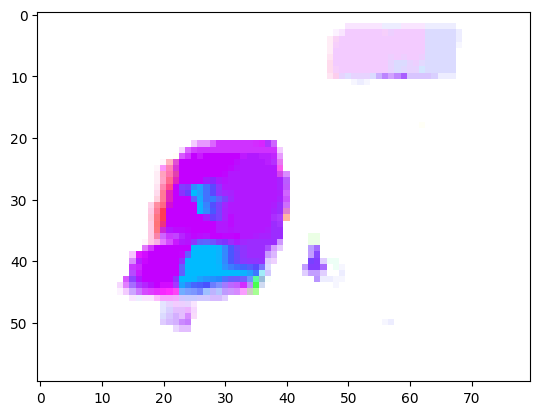

In [11]:
plt.imshow(block)

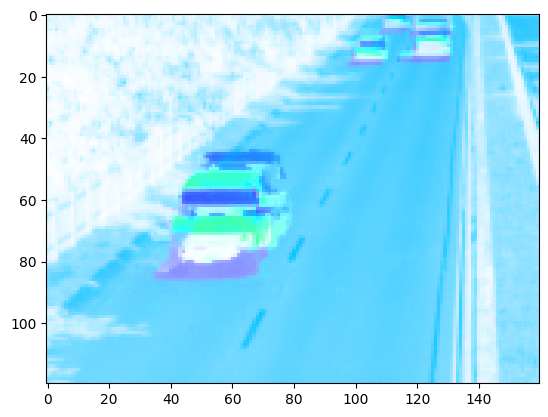

In [12]:
plt.imshow(multi, cmap='hsv')